# Time Series Analysis: Introduction

#### Goal of this section

We will learn different aspect of time series analysis

In the end, you will be able to analyze the time series data.

The different functionalities we will learn:
* Time index
* Creating time index
* Resampling
* Rolling windows

Analysis:
* Visualising the time series data
* Finding trend
* Calculating summaries

# Imports


In [1]:
import datetime
import os
import ipywidgets as widgets
from IPython.display import display

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 6)})

# Creating Dataset from raw files

## Data Description

**Motion and heart rate from a wrist-worn wearable and labeled sleep from polysomnography**

Taken from : https://physionet.org/content/sleep-accel/1.0.0/


The following types of data are provided: 

* **motion (acceleration)**:
     - Recorded from the Apple Watch and saved as txt files with the naming convention `[subject-id-number]_acceleration.txt`
     - Each line in this file has the format: date (in seconds since PSG start), x acceleration (in g), y acceleration, z acceleration
 
* **heart rate (bpm)**:
     - Recorded from the Apple Watch and saved as txt files with the naming convention `[subject-id-number]_heartrate.txt`
     - Each line in this file has the format: date (in seconds since PSG start), heart rate (bpm)
 
* **steps (count)**:
     - Recorded from the Apple Watch and saved in the format `[subject-id-number]_steps.txt`
     - Each line in this file has the format: date (in seconds since PSG start), steps (total in bin from this timestamp to next timestamp)
 
* **labeled sleep**:
     - Recorded from polysomnography and saved in the format `[subject-id-number]_labeled_sleep.txt`
     - Each line in this file has the format: date (in seconds since PSG start) stage 0-5:
         - wake = 0
         - N1 = 1
         - N2 = 2
         - N3 = 3
         - REM = 5

#### Lets check the files present in each folder

In [2]:
ls ../Datasets/sleep-accel/heart_rate/

1066528_heartrate.txt  4426783_heartrate.txt  8173033_heartrate.txt
1360686_heartrate.txt  46343_heartrate.txt    8258170_heartrate.txt
1449548_heartrate.txt  5132496_heartrate.txt  844359_heartrate.txt
1455390_heartrate.txt  5383425_heartrate.txt  8530312_heartrate.txt
1818471_heartrate.txt  5498603_heartrate.txt  8686948_heartrate.txt
2598705_heartrate.txt  5797046_heartrate.txt  8692923_heartrate.txt
2638030_heartrate.txt  6220552_heartrate.txt  9106476_heartrate.txt
3509524_heartrate.txt  759667_heartrate.txt   9618981_heartrate.txt
3997827_heartrate.txt  7749105_heartrate.txt  9961348_heartrate.txt
4018081_heartrate.txt  781756_heartrate.txt
4314139_heartrate.txt  8000685_heartrate.txt


In [3]:
ls ../Datasets/sleep-accel/steps/

1066528_steps.txt  3997827_steps.txt  5797046_steps.txt  844359_steps.txt
1360686_steps.txt  4018081_steps.txt  6220552_steps.txt  8530312_steps.txt
1449548_steps.txt  4314139_steps.txt  759667_steps.txt   8686948_steps.txt
1455390_steps.txt  4426783_steps.txt  7749105_steps.txt  8692923_steps.txt
1818471_steps.txt  46343_steps.txt    781756_steps.txt   9106476_steps.txt
2598705_steps.txt  5132496_steps.txt  8000685_steps.txt  9618981_steps.txt
2638030_steps.txt  5383425_steps.txt  8173033_steps.txt  9961348_steps.txt
3509524_steps.txt  5498603_steps.txt  8258170_steps.txt


In [4]:
ls ../Datasets/sleep-accel/labels/

1066528_labeled_sleep.txt  5797046_labeled_sleep.txt
1360686_labeled_sleep.txt  6220552_labeled_sleep.txt
1449548_labeled_sleep.txt  759667_labeled_sleep.txt
1455390_labeled_sleep.txt  7749105_labeled_sleep.txt
1818471_labeled_sleep.txt  781756_labeled_sleep.txt
2598705_labeled_sleep.txt  8000685_labeled_sleep.txt
2638030_labeled_sleep.txt  8173033_labeled_sleep.txt
3509524_labeled_sleep.txt  8258170_labeled_sleep.txt
3997827_labeled_sleep.txt  844359_labeled_sleep.txt
4018081_labeled_sleep.txt  8530312_labeled_sleep.txt
4314139_labeled_sleep.txt  8686948_labeled_sleep.txt
4426783_labeled_sleep.txt  8692923_labeled_sleep.txt
46343_labeled_sleep.txt    9106476_labeled_sleep.txt
5132496_labeled_sleep.txt  9618981_labeled_sleep.txt
5383425_labeled_sleep.txt  9961348_labeled_sleep.txt
5498603_labeled_sleep.txt


#### Lets Load some files and see what is inside!

In [5]:
user = "7749105"

Loading Heart rate Files. 

In [6]:
hr_df = pd.read_csv(f"../Datasets/sleep-accel/heart_rate/{user}_heartrate.txt", names=["Time", "HR"])
hr_df.head()

,Time,HR
0,-604388.47927,78
1,-604244.48025,78
2,-603816.10546,78
3,-603597.73132,78
4,-603463.23269,77


Here the `Time` is offset from the Sleep study start. SO lets ignore all the data recorded before the sleep

In [7]:
hr_df = hr_df[hr_df.Time > 0]
hr_df.head()

,Time,HR
1539,4.56596,72
1540,9.56596,73
1541,14.56596,73
1542,20.56596,73
1543,25.56596,71


Loading Sleep Stage Files. 

In [8]:
labels_df = pd.read_csv(f"../Datasets/sleep-accel/labels/{user}_labeled_sleep.txt", sep=" ", names=["Time", "Stage"])
labels_df.head()

,Time,Stage
0,0,-1
1,30,-1
2,60,-1
3,90,-1
4,120,-1


Loading Steps Files. 

In [9]:
steps_df = pd.read_csv(f"../Datasets/sleep-accel/steps/{user}_steps.txt", names=["Time", "Steps"])
steps_df = steps_df[steps_df.Time >= 0]  # similar to HR files, considering only sleep related data
steps_df.head()

,Time,Steps
1008,193,0
1009,793,0
1010,1393,0
1011,1993,0
1012,2593,0


Lets see how we can merge this per user data into single DataFrame

In [10]:
# Join Steps and Sleep Stage labels with pandas Merge
merged_df = pd.merge(labels_df, steps_df, how="outer", on="Time")
merged_df.head()

,Time,Stage,Steps
0,0,-1.0,NaN
1,30,-1.0,NaN
2,60,-1.0,NaN
3,90,-1.0,NaN
4,120,-1.0,NaN


In [11]:
# Since HR is recorded at floating times, merging is not a better idea
# So just concat the HR data
merged_df = pd.concat([merged_df, hr_df])
merged_df.head()

,Time,Stage,Steps,HR
0,0.0,-1.0,NaN,NaN
1,30.0,-1.0,NaN,NaN
2,60.0,-1.0,NaN,NaN
3,90.0,-1.0,NaN,NaN
4,120.0,-1.0,NaN,NaN


In [12]:
# Sort data by time
merged_df = merged_df.sort_values("Time")
merged_df.head()

,Time,Stage,Steps,HR
0,0.00000,-1.0,NaN,NaN
1539,4.56596,NaN,NaN,72.0
1540,9.56596,NaN,NaN,73.0
1541,14.56596,NaN,NaN,73.0
1542,20.56596,NaN,NaN,73.0


In [13]:
# Function to generate random date
def get_random(options):
    s = np.random.randint(0, len(options))
    return options[s]

def get_random_date():
    years = [2020, 2019, 2017]
    months = range(1, 13)
    days = range(1, 28)
    hours = [21, 22, 23, 0]
    minutes = range(60)

    return datetime.datetime(year=get_random(years),
                             month=get_random(months),
                             day=get_random(days),
                             hour=get_random(hours),
                             minute=get_random(minutes))

In [14]:
# The recorded time is elapsed time, so lets convert into datetime object
start_date = get_random_date()  # generating random date
merged_df.Time = merged_df.Time.apply(lambda x: start_date + datetime.timedelta(seconds=x))

# Set Time as index
merged_df.set_index("Time", inplace=True, drop=True)

# Add User ID as column
merged_df["UserID"] = user
merged_df.head()

,Stage,Steps,HR,UserID
Time,,,,
2020-09-02 21:12:00.000000,-1.0,NaN,NaN,7749105
2020-09-02 21:12:04.565960,NaN,NaN,72.0,7749105
2020-09-02 21:12:09.565960,NaN,NaN,73.0,7749105
2020-09-02 21:12:14.565960,NaN,NaN,73.0,7749105
2020-09-02 21:12:20.565960,NaN,NaN,73.0,7749105


In [15]:
# Fill NaN values
merged_df.Steps = merged_df.Steps.fillna(0)
merged_df.Stage = merged_df.Stage.fillna(method="ffill")
merged_df.head()

,Stage,Steps,HR,UserID
Time,,,,
2020-09-02 21:12:00.000000,-1.0,0.0,NaN,7749105
2020-09-02 21:12:04.565960,-1.0,0.0,72.0,7749105
2020-09-02 21:12:09.565960,-1.0,0.0,73.0,7749105
2020-09-02 21:12:14.565960,-1.0,0.0,73.0,7749105
2020-09-02 21:12:20.565960,-1.0,0.0,73.0,7749105


In [16]:
# convert sleep stage number into String as mentioned in the description
sleep_stage_mapping = {
    0: "wake",
    1: "N1",
    2: "N2",
    3: "N3",
    5: "REM"
}
merged_df.Stage = merged_df.Stage.map(sleep_stage_mapping)
merged_df = merged_df.dropna(subset=["Stage"])
merged_df.head()

,Stage,Steps,HR,UserID
Time,,,,
2020-09-02 21:18:00.000000,wake,0.0,NaN,7749105
2020-09-02 21:18:07.565960,wake,0.0,87.0,7749105
2020-09-02 21:18:12.565960,wake,0.0,81.0,7749105
2020-09-02 21:18:18.565930,wake,0.0,81.0,7749105
2020-09-02 21:18:23.565960,wake,0.0,78.0,7749105


#### Lets create Merged Data for each subject and create the dataet

In [17]:
def get_user_df(user):
    # Wrapping the above code into single function
    hr_df = pd.read_csv(f"../Datasets/sleep-accel/heart_rate/{user}_heartrate.txt", names=["Time", "HR"])
    hr_df = hr_df[hr_df.Time > 0]

    labels_df = pd.read_csv(f"../Datasets/sleep-accel/labels/{user}_labeled_sleep.txt", sep=" ", names=["Time", "Stage"])

    steps_df = pd.read_csv(f"../Datasets/sleep-accel/steps/{user}_steps.txt", names=["Time", "Steps"])
    steps_df = steps_df[steps_df.Time >= 0]

    merged_df = pd.merge(labels_df, steps_df, how="outer", on="Time")
    merged_df = pd.concat([merged_df, hr_df])
    merged_df = merged_df.sort_values("Time")
    
    start_date = get_random_date()
    merged_df.Time = merged_df.Time.apply(lambda x: start_date + datetime.timedelta(seconds=x))
    
    merged_df.set_index("Time", inplace=True, drop=True)
    merged_df["UserID"] = user
    
    merged_df.Stage = merged_df.Stage.fillna(method="ffill")
    merged_df.Steps = merged_df.Steps.fillna(0)
    
    sleep_stage_mapping = {
        0: "wake",
        1: "N1",
        2: "N2",
        3: "N3",
        5: "REM"
    }
    merged_df.Stage = merged_df.Stage.map(sleep_stage_mapping)
    merged_df = merged_df.dropna(subset=["Stage"])
    
    return merged_df

Get list of users and create Dataset

In [18]:
users = [s.split("_")[0] for s in os.listdir("../Datasets/sleep-accel/labels/")]
df_list = [get_user_df(user) for user in users]
df = pd.concat(df_list)
df.head()

,Stage,Steps,HR,UserID
Time,,,,
2020-02-17 00:59:00.000000,wake,0.0,NaN,4426783
2020-02-17 00:59:03.285720,wake,0.0,71.0,4426783
2020-02-17 00:59:07.285750,wake,0.0,71.0,4426783
2020-02-17 00:59:13.285750,wake,0.0,72.0,4426783
2020-02-17 00:59:23.285750,wake,0.0,61.0,4426783


Save the dataset for future purpose

In [19]:
df.to_csv("../Datasets/sleep_with_hr.csv")



# Visualise data

This section uses the iPython widgets to allow us to load any data on demand

Lets see some basic example of widgets

**Dropdown menu**

In [20]:
widgets.Dropdown(
        options=["Option1", "Option2", "Option3"],
        # value=1,
        description="Options",
        disabled=False,
    )

Dropdown(description='Options', options=('Option1', 'Option2', 'Option3'), value='Option1')

**Button**

In [21]:
button = widgets.Button(
        description="Button Demo",
        disabled=False,
        button_style='success', # 'success', 'info', 'warning', 'danger' or ''
        tooltip="button",
        indent=1,
        # icon='check' # (FontAwesome names without the `fa-` prefix)
    )

def callback(*args):
    print("Hello")
    
button.on_click(callback)
button

Button(button_style='success', description='Button Demo', style=ButtonStyle(), tooltip='button')

**Multiple Choice List**

In [22]:
widgets.SelectMultiple(
        options=["Option1", "Option2", "Option3"],
        value=[],
        rows=5,
        description="Multiple select",
        disabled=False)

SelectMultiple(description='Multiple select', options=('Option1', 'Option2', 'Option3'), value=())

#### Wrap that into functions and create utility with widgets

Widget functions

In [23]:
 def get_dropdown_list(label, options):
    return widgets.Dropdown(
        options=options,
        # value=1,
        description=label,
        disabled=False,
    )

def get_button(label, callback):
    button = widgets.Button(
        description=label,
        disabled=False,
        button_style='success', # 'success', 'info', 'warning', 'danger' or ''
        tooltip=label,
        indent=1,
        # icon='check' # (FontAwesome names without the `fa-` prefix)
    )
    button.on_click(callback)
    return button

def get_multiple_option_box(label, options, num_rows=15):
    return widgets.SelectMultiple(
        options=options,
        value=[],
        rows=num_rows,
        description=label,
        disabled=False
    )

Ploty plot, for interactive plots. Read more about it here: https://plotly.com/

In [24]:
def plot_user(user_df, cols):
    fig = make_subplots(rows=len(cols), cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.02)

    for (i, col) in enumerate(cols):
        labels=dict(x="Time (s)", y=col)
        temp_df = user_df.dropna(subset=[col])

        trace = go.Scatter(x=temp_df.index, y=temp_df[col].values, mode="lines", name=col)
        fig.add_trace(trace, row=i+1, col=1)

    title = f"User: {user_df.UserID.unique()[0]}"
    fig.update_layout(height=200 * len(cols) + 100, width=1200, title_text=title)
    fig.show()

Main function that connects the widgets and generate the plot

In [25]:
def plot_sleep(df):
    def plot_callback(*args):
        with analysis_output:
            analysis_output.clear_output()
            analysis_btn.description = "Plotting.."
            analysis_btn.button_style = "info"
                        
            print("waiting..")
            print(option_list1.value, mult_options.value)
            user_df = df[df.UserID == option_list1.value]
            plot_user(user_df, mult_options.value)
            analysis_btn.description = "Generate Plot"
            analysis_btn.button_style = "success"

    user_options = list(df.UserID.unique())
    column_options = list(df.columns[:-1])
    option_list1 = get_dropdown_list("Select User:", ["-"] + user_options)
    # option_list1.observe(on_value_change, names='value')
    
    analysis_btn = get_button("Generate Plot", plot_callback)
    
    label = widgets.Label(value="(Select multiple by keeping Ctrl / Cmd pressed while selecting)")
    mult_options = get_multiple_option_box("Multiple selection var", column_options, 4)
    
    grp = widgets.VBox([option_list1, widgets.HBox([mult_options, label]), analysis_btn])
    analysis_output = widgets.Output()
    return widgets.VBox([grp, analysis_output])

In [26]:
plot_sleep(df)

# Learn basics of time series

Some things are taken from this [Reference](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/)

## Time series data structures


In [27]:
pd.to_datetime('2018-01-15 3:45pm')

Timestamp('2018-01-15 15:45:00')

In [28]:
pd.to_datetime('2012-02-02 10:40')

Timestamp('2012-02-02 10:40:00')

In [29]:
pd.to_datetime('7/8/2021')

Timestamp('2021-07-08 00:00:00')

As we can see, to_datetime() automatically infers a date/time format based on the input. In the example above, the ambiguous date '7/8/1952' is assumed to be month/day/year and is interpreted as July 8, 1952. Alternatively, we can use the dayfirst parameter to tell pandas to interpret the date as August 7, 1952.

In [30]:
pd.to_datetime('7/8/1952', dayfirst=True)

Timestamp('1952-08-07 00:00:00')

If we supply a list or array of strings as input to to_datetime(), it returns a sequence of date/time values in a DatetimeIndex object, which is the core data structure that powers much of pandas time series functionality.



In [31]:
pd.to_datetime(['2018-01-05', '7/8/1952', 'Oct 10, 1995'])

DatetimeIndex(['2018-01-05', '1952-07-08', '1995-10-10'], dtype='datetime64[ns]', freq=None)

## Time-based indexing


Lets see how can we access the data using this time. Lets try to load some data from out existing dataset

In [32]:
df.loc["2019-01-06"]  # Accessing 1st June's data

,Stage,Steps,HR,UserID
Time,,,,


In [33]:
df.loc["2019-01-06": "2019-01-07"]  # Accessing 1st June to 10 June data

/var/folders/l8/bp1nvw7j7zl3sm7zc666s2680000gn/T/ipykernel_41039/310543045.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df.loc["2019-01-06": "2019-01-07"]  # Accessing 1st June to 10 June data


,Stage,Steps,HR,UserID
Time,,,,


In [34]:
df.loc["2019-01"]  # Load all data from "January"

,Stage,Steps,HR,UserID
Time,,,,


In [35]:
df.loc["2019"]  # Load all data from 2019

,Stage,Steps,HR,UserID
Time,,,,
2019-10-27 21:47:30.000000,wake,0.0,NaN,5498603
2019-10-27 21:47:31.808850,wake,0.0,68.0,5498603
2019-10-27 21:47:34.000000,wake,14.0,NaN,5498603
2019-10-27 21:47:37.808820,wake,0.0,68.0,5498603
2019-10-27 21:47:42.808850,wake,0.0,68.0,5498603
...,...,...,...,...
2019-03-03 05:19:05.900170,wake,0.0,61.0,4314139
2019-03-03 05:19:10.900210,wake,0.0,61.0,4314139
2019-03-03 05:19:16.900210,wake,0.0,62.0,4314139


## Creating time index

**Frequency**

When the data points of a time series are uniformly spaced in time (e.g., hourly, daily, monthly, etc.), the time series can be associated with a frequency in pandas. For example, let’s use the date_range() function to create a sequence of uniformly spaced dates.

In [36]:
# Providing the `period` as number of points
times = pd.date_range('2019-06-01', freq='15T', periods=100)
times

DatetimeIndex(['2019-06-01 00:00:00', '2019-06-01 00:15:00',
               '2019-06-01 00:30:00', '2019-06-01 00:45:00',
               '2019-06-01 01:00:00', '2019-06-01 01:15:00',
               '2019-06-01 01:30:00', '2019-06-01 01:45:00',
               '2019-06-01 02:00:00', '2019-06-01 02:15:00',
               '2019-06-01 02:30:00', '2019-06-01 02:45:00',
               '2019-06-01 03:00:00', '2019-06-01 03:15:00',
               '2019-06-01 03:30:00', '2019-06-01 03:45:00',
               '2019-06-01 04:00:00', '2019-06-01 04:15:00',
               '2019-06-01 04:30:00', '2019-06-01 04:45:00',
               '2019-06-01 05:00:00', '2019-06-01 05:15:00',
               '2019-06-01 05:30:00', '2019-06-01 05:45:00',
               '2019-06-01 06:00:00', '2019-06-01 06:15:00',
               '2019-06-01 06:30:00', '2019-06-01 06:45:00',
               '2019-06-01 07:00:00', '2019-06-01 07:15:00',
               '2019-06-01 07:30:00', '2019-06-01 07:45:00',
               '2019-06-

In [37]:
# Providing the `end` as number of points
times = pd.date_range('2019-06-01', '2019-06-02', freq='15T')
times

DatetimeIndex(['2019-06-01 00:00:00', '2019-06-01 00:15:00',
               '2019-06-01 00:30:00', '2019-06-01 00:45:00',
               '2019-06-01 01:00:00', '2019-06-01 01:15:00',
               '2019-06-01 01:30:00', '2019-06-01 01:45:00',
               '2019-06-01 02:00:00', '2019-06-01 02:15:00',
               '2019-06-01 02:30:00', '2019-06-01 02:45:00',
               '2019-06-01 03:00:00', '2019-06-01 03:15:00',
               '2019-06-01 03:30:00', '2019-06-01 03:45:00',
               '2019-06-01 04:00:00', '2019-06-01 04:15:00',
               '2019-06-01 04:30:00', '2019-06-01 04:45:00',
               '2019-06-01 05:00:00', '2019-06-01 05:15:00',
               '2019-06-01 05:30:00', '2019-06-01 05:45:00',
               '2019-06-01 06:00:00', '2019-06-01 06:15:00',
               '2019-06-01 06:30:00', '2019-06-01 06:45:00',
               '2019-06-01 07:00:00', '2019-06-01 07:15:00',
               '2019-06-01 07:30:00', '2019-06-01 07:45:00',
               '2019-06-

## Resampling

Lets create sample dataset using the information above

In [38]:
# Generate values at each seconds
num_points = 10
times = pd.date_range('2019-06-01', freq='1s', periods=num_points)
values = range(num_points)
temp_df = pd.DataFrame({"time": times, "a": values})
temp_df = temp_df.set_index("time")
temp_df

,a
time,
2019-06-01 00:00:00,0
2019-06-01 00:00:01,1
2019-06-01 00:00:02,2
2019-06-01 00:00:03,3
2019-06-01 00:00:04,4
2019-06-01 00:00:05,5
2019-06-01 00:00:06,6
2019-06-01 00:00:07,7
2019-06-01 00:00:08,8


In [39]:
temp_df.resample("2s").mean()

,a
time,
2019-06-01 00:00:00,0.5
2019-06-01 00:00:02,2.5
2019-06-01 00:00:04,4.5
2019-06-01 00:00:06,6.5
2019-06-01 00:00:08,8.5


Lets see how it works

<img src="../Assets/resample_mean.png" width="600" height="600"/>

In [40]:
temp_df.resample("2s").sum()

,a
time,
2019-06-01 00:00:00,1
2019-06-01 00:00:02,5
2019-06-01 00:00:04,9
2019-06-01 00:00:06,13
2019-06-01 00:00:08,17


## Rolling windows

In [41]:
temp_rolling_df = pd.DataFrame({"a": range(100, 110)})
temp_rolling_df

,a
0,100
1,101
2,102
3,103
4,104
5,105
6,106
7,107
8,108
9,109


Lets see how it works

<img src="../Assets/rolling_mean1.png" width="600" height="600"/>

--------------------------------------------------------------------------------

<img src="../Assets/rolling_mean2.png" width="1000" height="600"/>

In [42]:
temp_rolling_df["rolling_mean"] = temp_rolling_df.a.rolling(5, min_periods=5, center=True).mean()
temp_rolling_df

,a,rolling_mean
0,100,NaN
1,101,NaN
2,102,102.0
3,103,103.0
4,104,104.0
5,105,105.0
6,106,106.0
7,107,107.0
8,108,NaN
9,109,NaN


In [43]:
temp_rolling_df["rolling_mean"] = temp_rolling_df.a.rolling(5, min_periods=1, center=False).mean()
temp_rolling_df

,a,rolling_mean
0,100,100.0
1,101,100.5
2,102,101.0
3,103,101.5
4,104,102.0
5,105,103.0
6,106,104.0
7,107,105.0
8,108,106.0
9,109,107.0


In [44]:
temp_rolling_df["rolling_mean"] = temp_rolling_df.a.rolling(5, min_periods=5, center=False).mean()
temp_rolling_df

,a,rolling_mean
0,100,NaN
1,101,NaN
2,102,NaN
3,103,NaN
4,104,102.0
5,105,103.0
6,106,104.0
7,107,105.0
8,108,106.0
9,109,107.0


Rolling based on time instead of index

In [45]:
temp_df.rolling("2s").mean()

,a
time,
2019-06-01 00:00:00,0.0
2019-06-01 00:00:01,0.5
2019-06-01 00:00:02,1.5
2019-06-01 00:00:03,2.5
2019-06-01 00:00:04,3.5
2019-06-01 00:00:05,4.5
2019-06-01 00:00:06,5.5
2019-06-01 00:00:07,6.5
2019-06-01 00:00:08,7.5


# Questions

## How to visualise smooth HR?

In [46]:
user = users[0]
user_df = df[df.UserID == user]
user_df.head()

,Stage,Steps,HR,UserID
Time,,,,
2020-02-17 00:59:00.000000,wake,0.0,NaN,4426783
2020-02-17 00:59:03.285720,wake,0.0,71.0,4426783
2020-02-17 00:59:07.285750,wake,0.0,71.0,4426783
2020-02-17 00:59:13.285750,wake,0.0,72.0,4426783
2020-02-17 00:59:23.285750,wake,0.0,61.0,4426783


Text(0, 0.5, 'Heart rate')

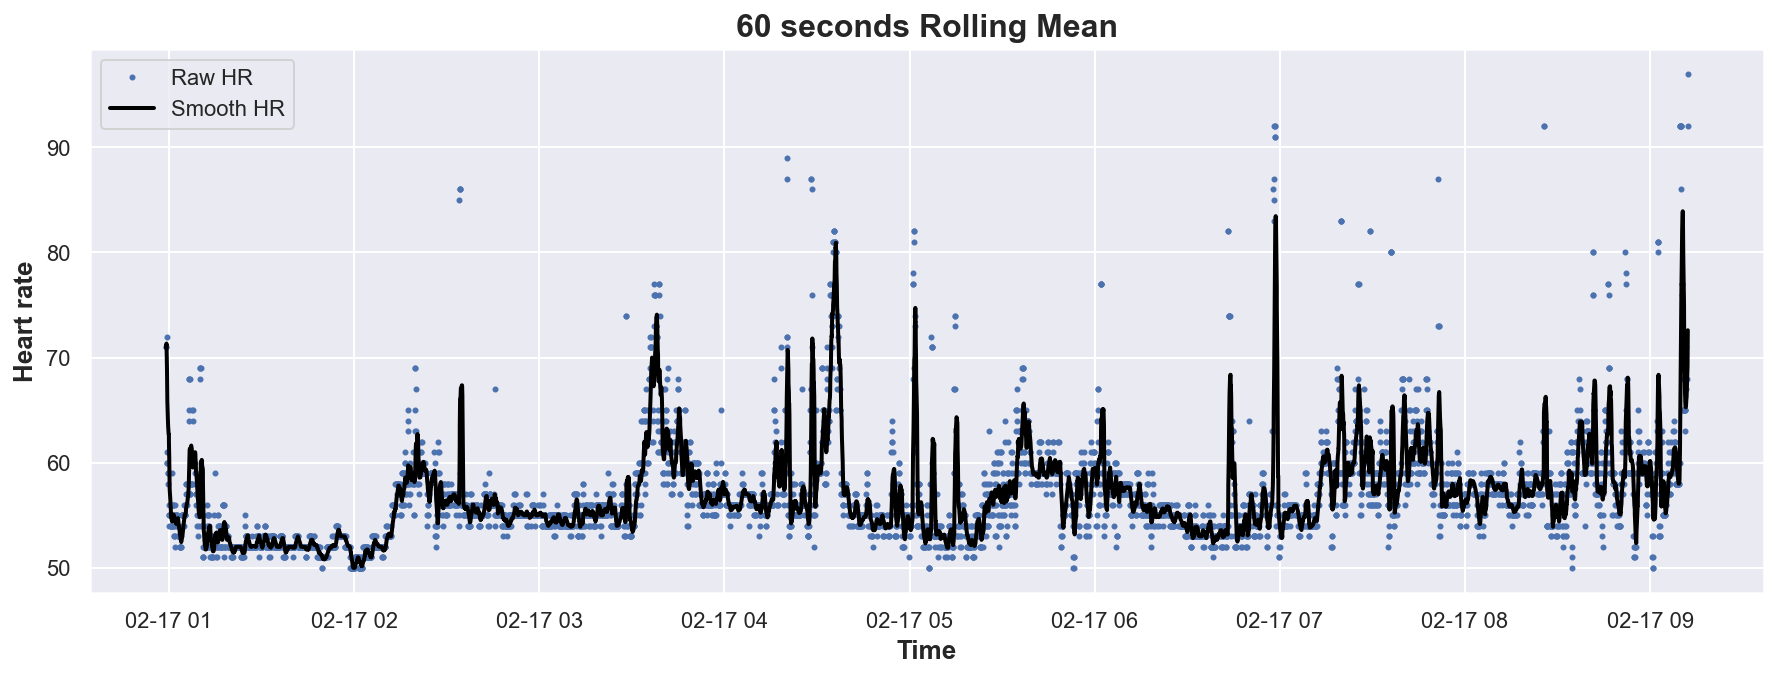

In [47]:
raw_hr = user_df.HR
recalculated_hr = user_df.HR.rolling("60s").mean()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(raw_hr, 'o', markersize=2, label="Raw HR")
ax.plot(recalculated_hr, linewidth=2, color="black", label="Smooth HR")
ax.legend()
ax.set_title("60 seconds Rolling Mean", fontsize=16, fontweight="bold")
ax.set_xlabel("Time", fontsize=13, fontweight="bold")
ax.set_ylabel("Heart rate", fontsize=13, fontweight="bold")

Text(0, 0.5, 'Heart rate')

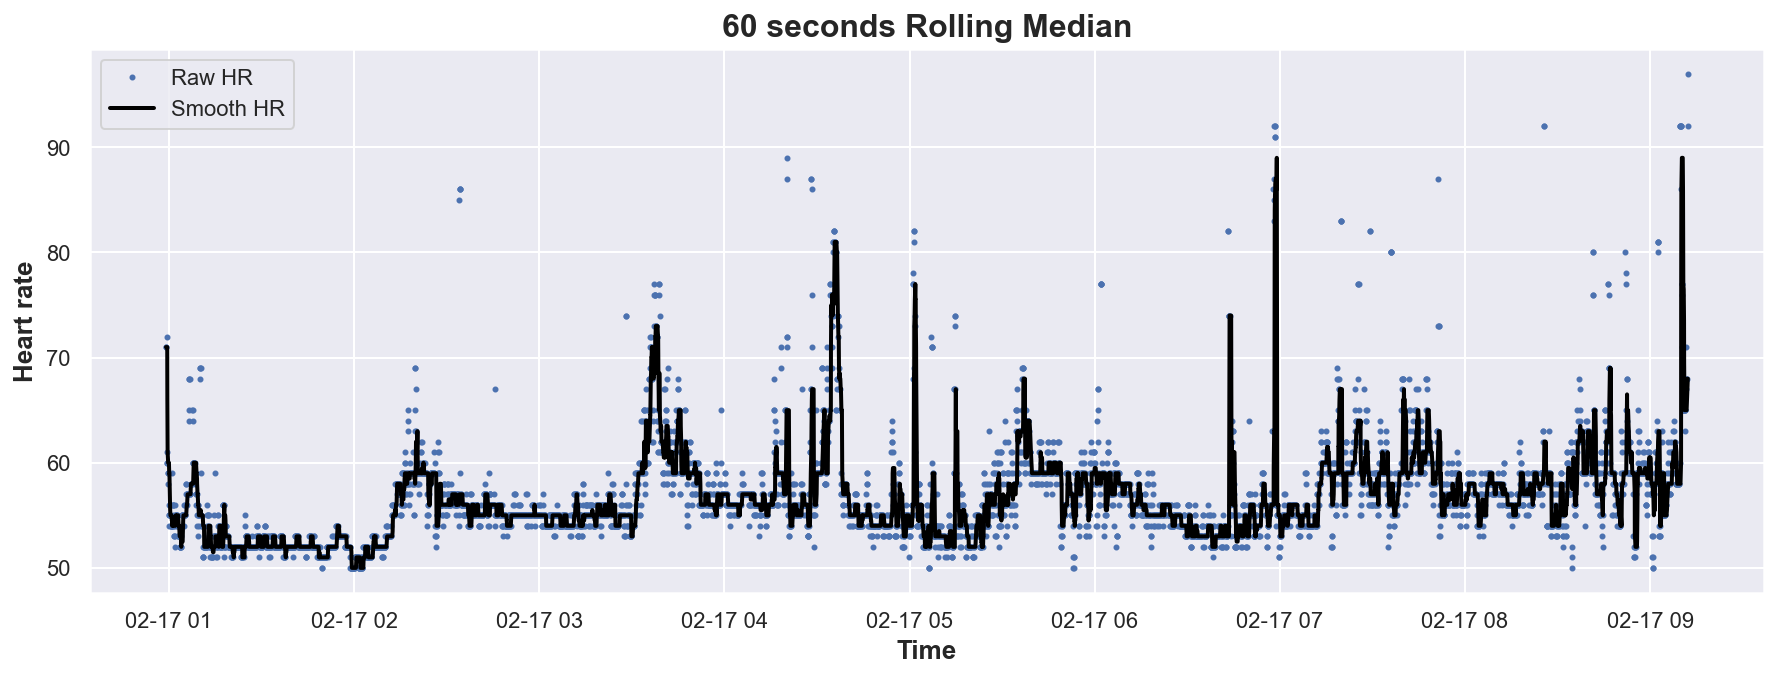

In [48]:
raw_hr = user_df.HR
recalculated_hr = user_df.HR.rolling("60s").median()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(raw_hr, 'o', markersize=2, label="Raw HR")
ax.plot(recalculated_hr, linewidth=2, color="black", label="Smooth HR")
ax.legend()
ax.set_title("60 seconds Rolling Median", fontsize=16, fontweight="bold")
ax.set_xlabel("Time", fontsize=13, fontweight="bold")
ax.set_ylabel("Heart rate", fontsize=13, fontweight="bold")

Text(0, 0.5, 'Heart rate')

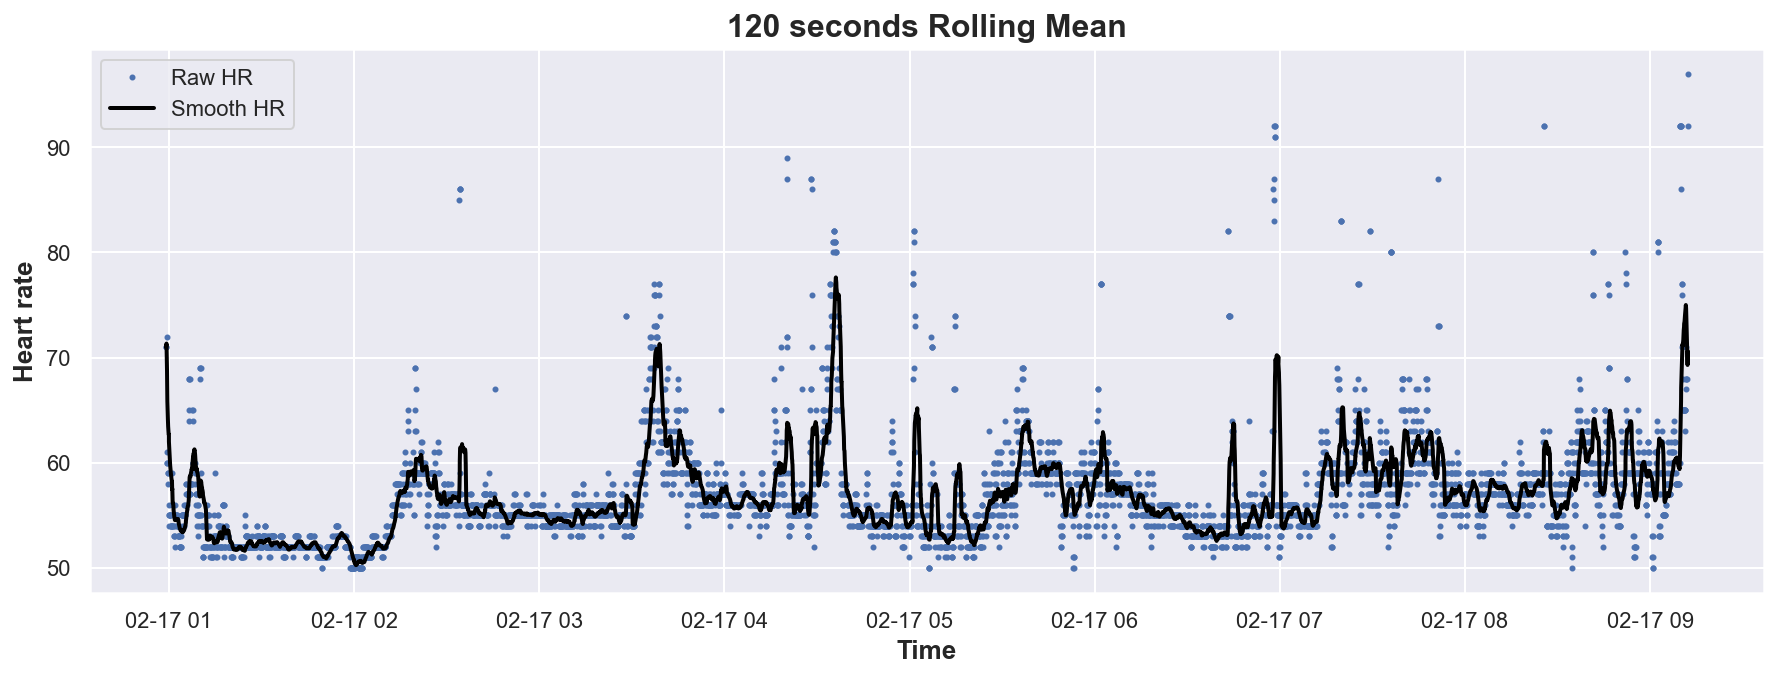

In [49]:
raw_hr = user_df.HR
recalculated_hr = user_df.HR.rolling("120s").mean()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(raw_hr, 'o', markersize=2, label="Raw HR")
ax.plot(recalculated_hr, linewidth=2, color="black", label="Smooth HR")
ax.legend()
ax.set_title("120 seconds Rolling Mean", fontsize=16, fontweight="bold")
ax.set_xlabel("Time", fontsize=13, fontweight="bold")
ax.set_ylabel("Heart rate", fontsize=13, fontweight="bold")

Text(0, 0.5, 'Heart rate')

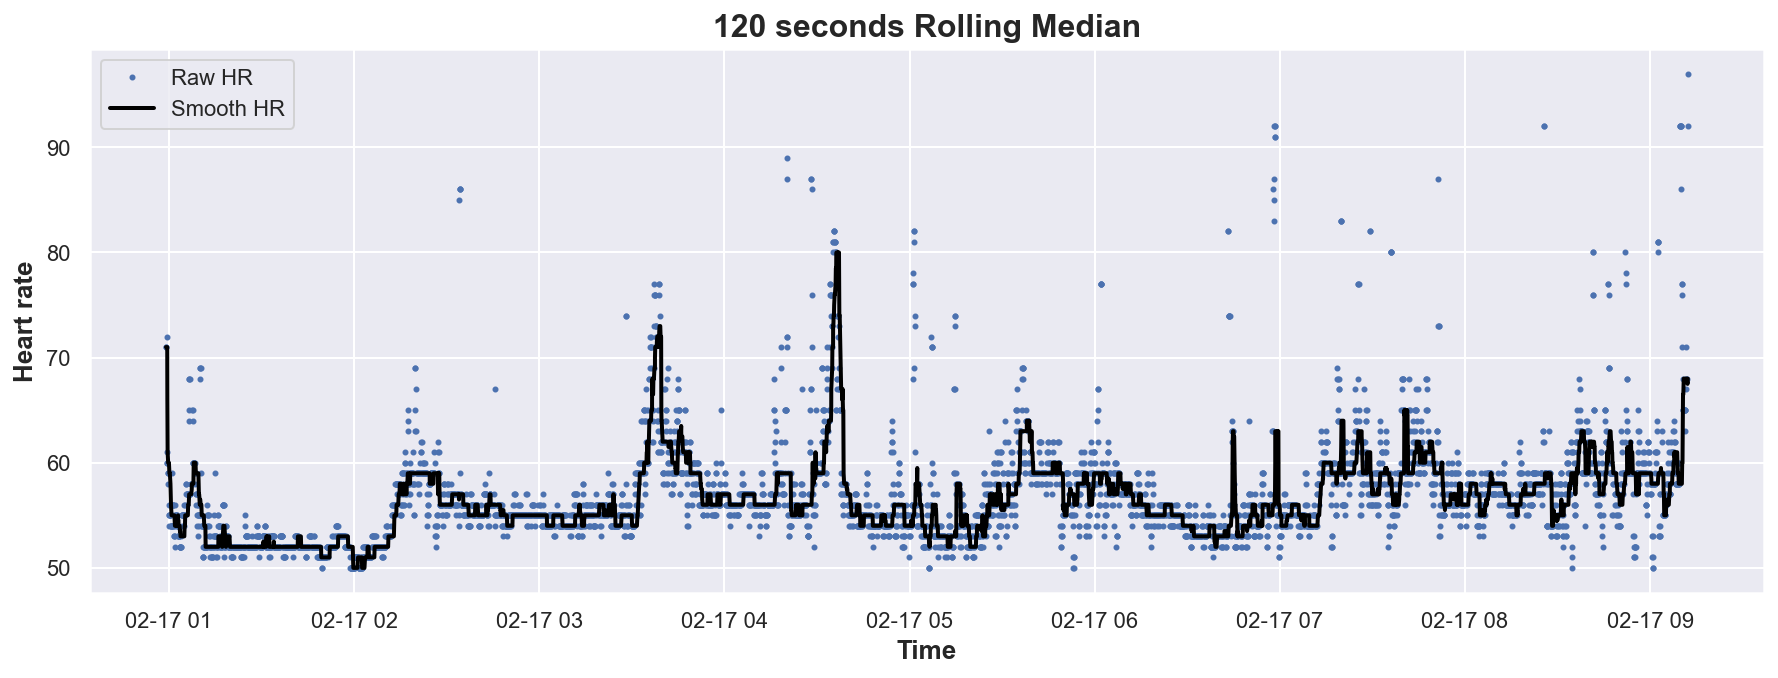

In [50]:
raw_hr = user_df.HR
recalculated_hr = user_df.HR.rolling("120s").median()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(raw_hr, 'o', markersize=2, label="Raw HR")
ax.plot(recalculated_hr, linewidth=2, color="black", label="Smooth HR")
ax.legend()
ax.set_title("120 seconds Rolling Median", fontsize=16, fontweight="bold")
ax.set_xlabel("Time", fontsize=13, fontweight="bold")
ax.set_ylabel("Heart rate", fontsize=13, fontweight="bold")

Text(0, 0.5, 'Heart rate')

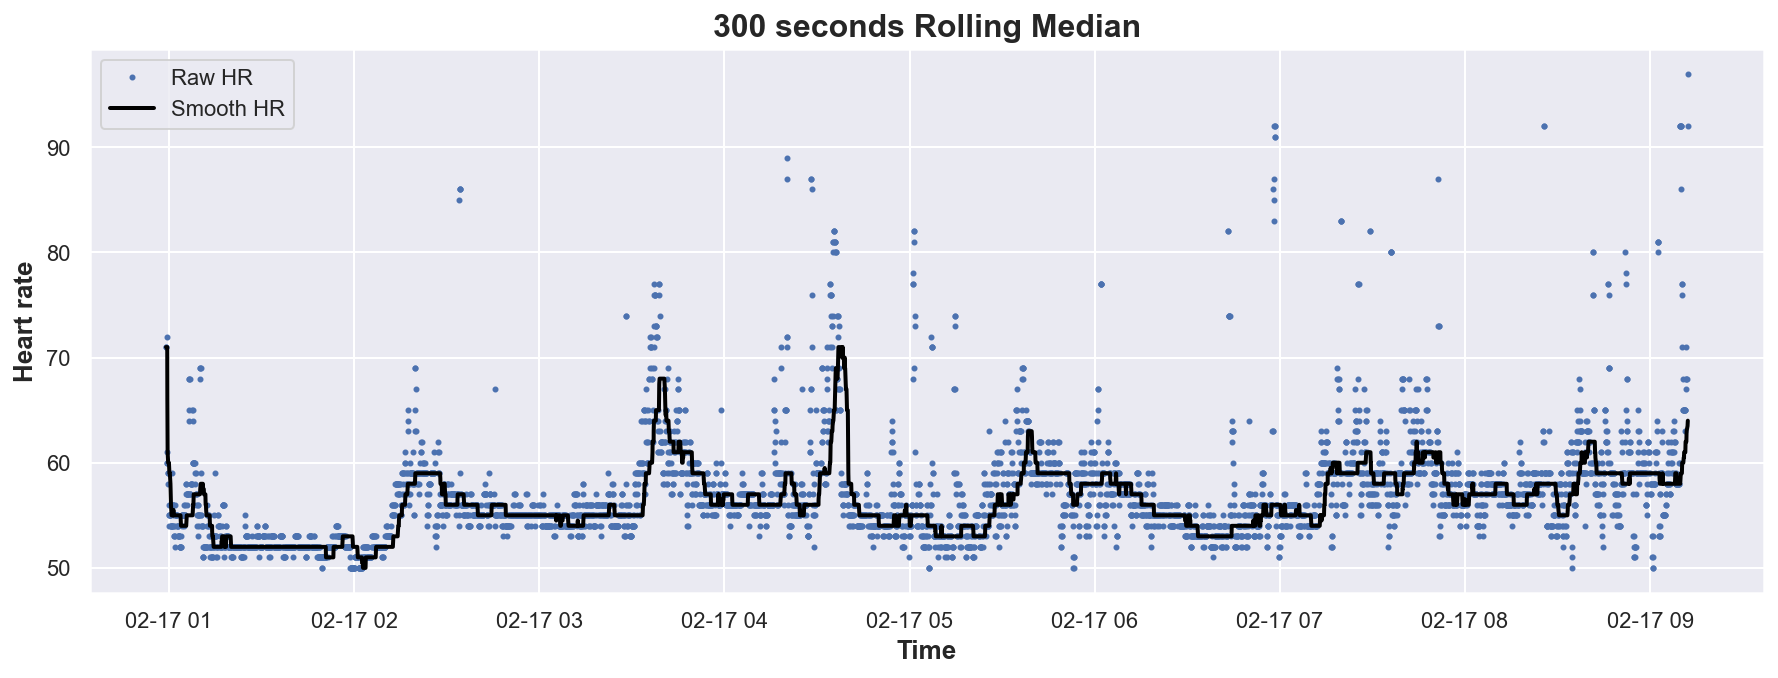

In [51]:
raw_hr = user_df.HR
recalculated_hr = user_df.HR.rolling("300s").median()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(raw_hr, 'o', markersize=2, label="Raw HR")
ax.plot(recalculated_hr, linewidth=2, color="black", label="Smooth HR")
ax.legend()
ax.set_title("300 seconds Rolling Median", fontsize=16, fontweight="bold")
ax.set_xlabel("Time", fontsize=13, fontweight="bold")
ax.set_ylabel("Heart rate", fontsize=13, fontweight="bold")

Text(0, 0.5, 'Heart rate')

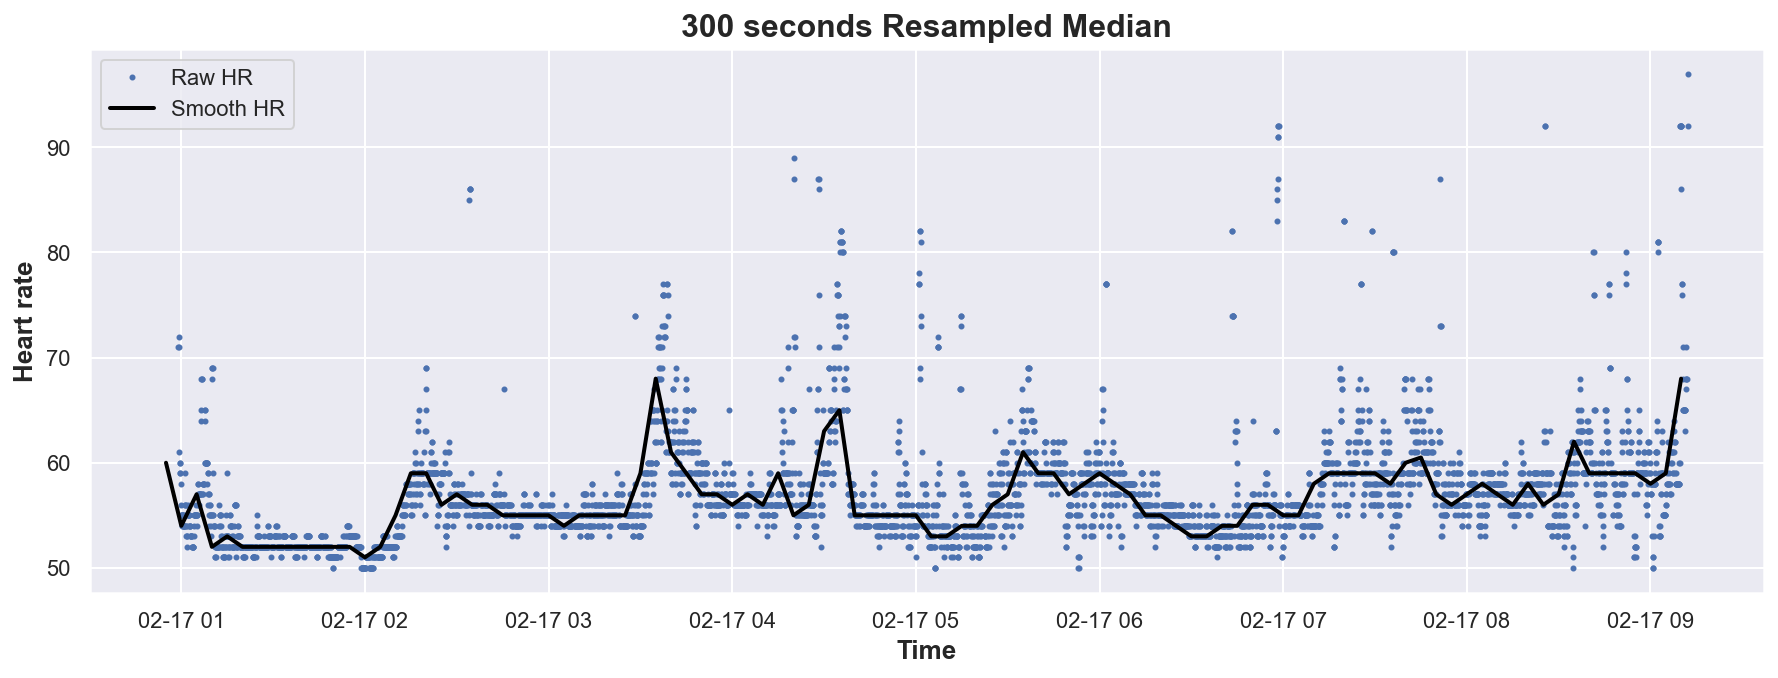

In [52]:
raw_hr = user_df.HR
recalculated_hr = user_df.HR.resample("300s").median()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(raw_hr, 'o', markersize=2, label="Raw HR")
ax.plot(recalculated_hr, linewidth=2, color="black", label="Smooth HR")
ax.legend()
ax.set_title("300 seconds Resampled Median", fontsize=16, fontweight="bold")
ax.set_xlabel("Time", fontsize=13, fontweight="bold")
ax.set_ylabel("Heart rate", fontsize=13, fontweight="bold")

Text(0, 0.5, 'Heart rate')

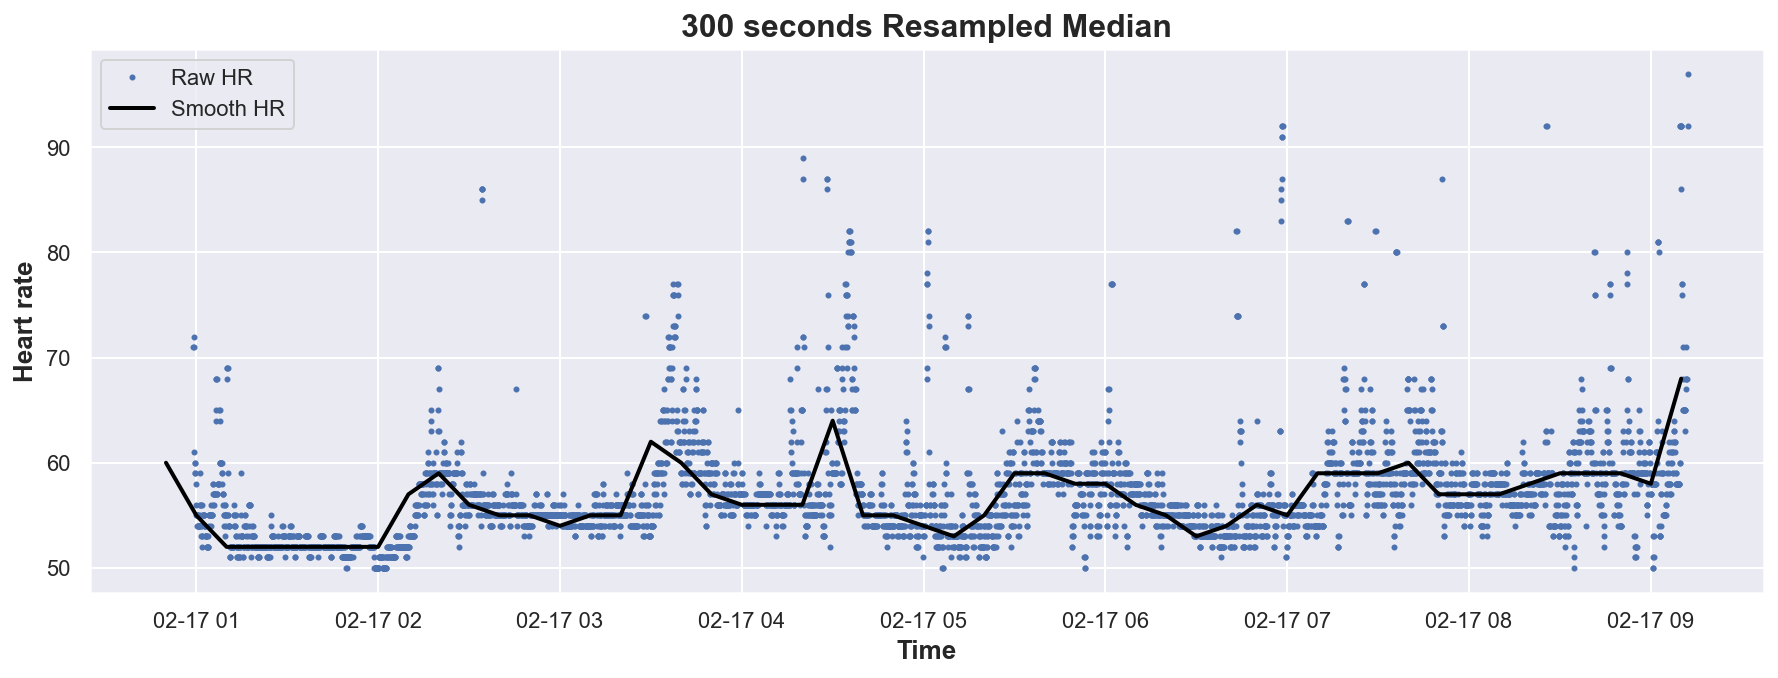

In [53]:
raw_hr = user_df.HR
recalculated_hr = user_df.HR.resample("600s").median()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(raw_hr, 'o', markersize=2, label="Raw HR")
ax.plot(recalculated_hr, linewidth=2, color="black", label="Smooth HR")
ax.legend()
ax.set_title("300 seconds Resampled Median", fontsize=16, fontweight="bold")
ax.set_xlabel("Time", fontsize=13, fontweight="bold")
ax.set_ylabel("Heart rate", fontsize=13, fontweight="bold")

## Is there any relation between sleep stage and HR?

Text(0, 0.5, 'STD of HR')

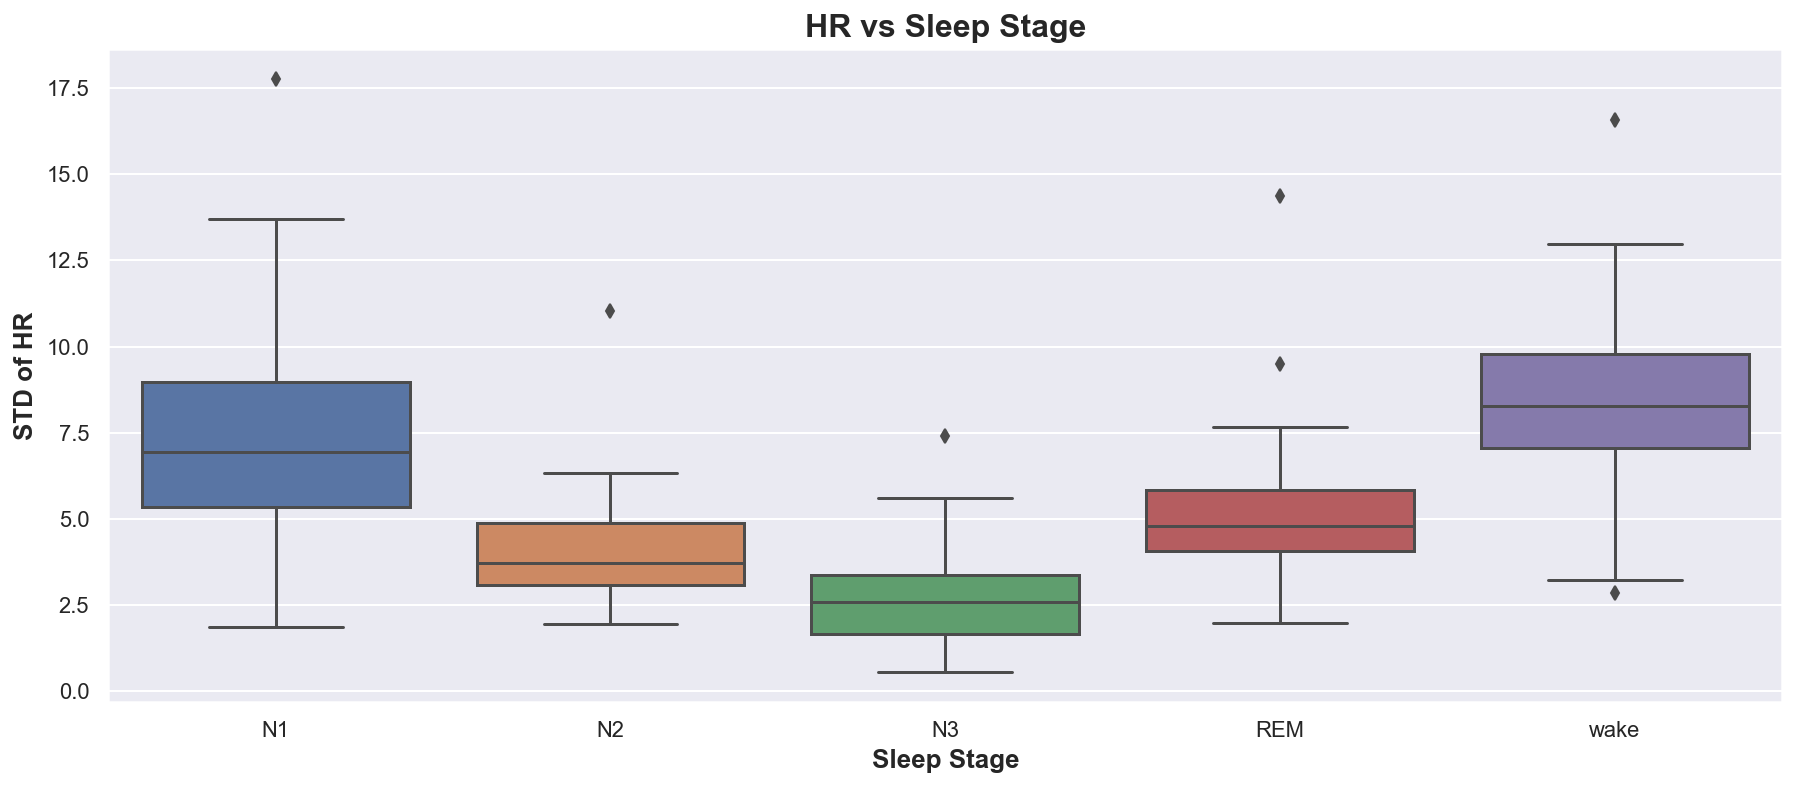

In [54]:
std_df = df.groupby(["UserID", "Stage"], as_index=False)[["HR", "Stage"]].std()
ax = sns.boxplot(x="Stage", y="HR", data=std_df)
ax.set_title("HR vs Sleep Stage", fontsize=16, fontweight="bold")
ax.set_xlabel("Sleep Stage", fontsize=13, fontweight="bold")
ax.set_ylabel("STD of HR", fontsize=13, fontweight="bold")

## What is the disctribution of individual sleep stages

In [55]:
ind_lens = df.groupby(["UserID", "Stage"])[["Stage"]].count()
ind_lens.head()

Stage
UserID  Stage       
1066528 N1      1516
        N2      5132
        N3      1130
        REM     5559
        wake    2519

In [56]:
total_lens = df.groupby("UserID").apply(lambda x: np.sum(x != "wake"))[["Stage"]]
total_lens.head()

,Stage
UserID,
1066528,13337
1360686,5659
1449548,5772
1455390,5948
1818471,6470


In [57]:
distributions = ind_lens / total_lens
distributions.head()

Stage
UserID  Stage          
1066528 N1     0.113669
        N2     0.384794
        N3     0.084727
        REM    0.416810
        wake   0.188873

In [58]:
distributions.columns = ["Percentage"]
distributions["Stage"] = distributions.droplevel(0).index
distributions.head()

Percentage Stage
UserID  Stage                  
1066528 N1       0.113669    N1
        N2       0.384794    N2
        N3       0.084727    N3
        REM      0.416810   REM
        wake     0.188873  wake

Text(15.828103472222232, 0.5, 'Density')

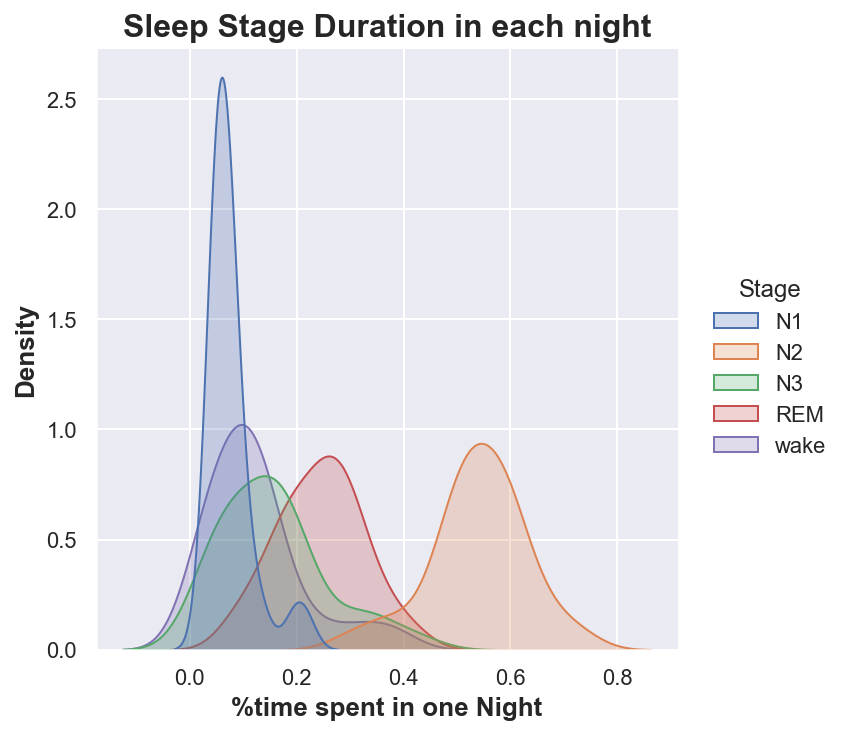

In [59]:
fig = sns.displot(distributions, x="Percentage", hue="Stage", kind="kde", fill=True)
fig.ax.set_title("Sleep Stage Duration in each night", fontsize=16, fontweight="bold")
fig.ax.set_xlabel("%time spent in one Night", fontsize=13, fontweight="bold")
fig.ax.set_ylabel("Density", fontsize=13, fontweight="bold")

## Months having the sleep data

Text(0, 0.5, 'No. of Nights')

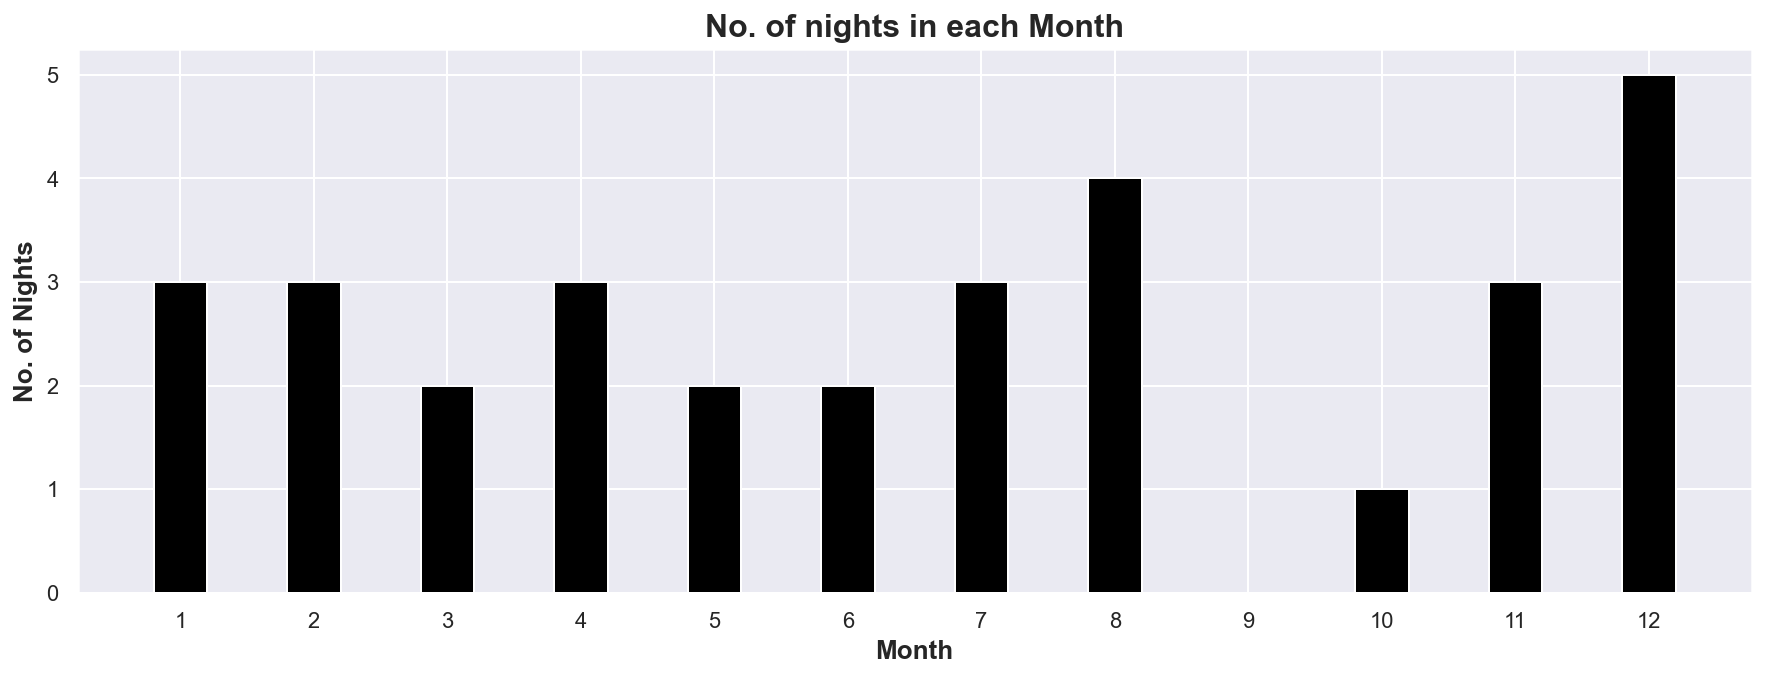

In [60]:
count_per_month = {str(month): len(df[df.index.month == month].groupby("UserID")) for month in range(1, 13)}
months = list(count_per_month.values())
counts = list(count_per_month.keys())

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(counts, months, 0.4, color="black")
ax.set_title("No. of nights in each Month", fontsize=16, fontweight="bold")
ax.set_xlabel("Month", fontsize=13, fontweight="bold")
ax.set_ylabel("No. of Nights", fontsize=13, fontweight="bold")

## Years having the Sleep data

In [61]:
unique_years = df.index.year.unique()
unique_years

Int64Index([2020, 2019, 2017], dtype='int64', name='Time')

Text(0, 0.5, 'No. of Nights')

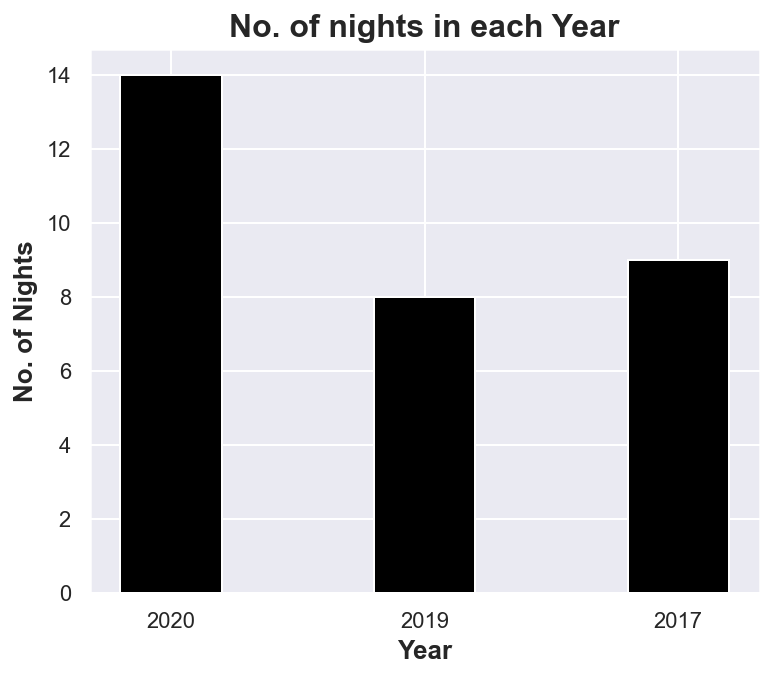

In [62]:
count_per_year = {str(year): len(df[df.index.year == year].groupby("UserID")) for year in unique_years}
years = list(count_per_year.values())
counts = list(count_per_year.keys())


fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.bar(counts, years, 0.4, color="black")
ax.set_title("No. of nights in each Year", fontsize=16, fontweight="bold")
ax.set_xlabel("Year", fontsize=13, fontweight="bold")
ax.set_ylabel("No. of Nights", fontsize=13, fontweight="bold")

## Sleep time Variation

#### How to extract a sleep time of a given user?

Load user data

In [63]:
user = df.UserID[0]
user_df = df[df.UserID == user]
print(f"Dataframe of the user: {user}")
user_df.head()

Dataframe of the user: 4426783


,Stage,Steps,HR,UserID
Time,,,,
2020-02-17 00:59:00.000000,wake,0.0,NaN,4426783
2020-02-17 00:59:03.285720,wake,0.0,71.0,4426783
2020-02-17 00:59:07.285750,wake,0.0,71.0,4426783
2020-02-17 00:59:13.285750,wake,0.0,72.0,4426783
2020-02-17 00:59:23.285750,wake,0.0,61.0,4426783


Find where sleep starts (when stage is not `wake`)

In [64]:
sleep_index = user_df.Stage != "wake"
sleep_index

Time
2020-02-17 00:59:00.000000    False
2020-02-17 00:59:03.285720    False
2020-02-17 00:59:07.285750    False
2020-02-17 00:59:13.285750    False
2020-02-17 00:59:23.285750    False
                              ...  
2020-02-17 09:11:38.150130     True
2020-02-17 09:11:43.150130     True
2020-02-17 09:11:48.150130     True
2020-02-17 09:12:06.432080     True
2020-02-17 09:12:11.431350     True
Name: Stage, Length: 6657, dtype: bool

Crop the only sleep data

In [65]:
sleep_df = user_df[sleep_index]
sleep_df.head()

,Stage,Steps,HR,UserID
Time,,,,
2020-02-17 01:12:00.000000,N1,0.0,NaN,4426783
2020-02-17 01:12:04.285720,N1,0.0,52.0,4426783
2020-02-17 01:12:11.285750,N1,0.0,52.0,4426783
2020-02-17 01:12:14.285720,N1,0.0,52.0,4426783
2020-02-17 01:12:19.285750,N1,0.0,54.0,4426783


Finf first occurance of sleep

In [66]:
sleep_time = sleep_df.index[0].time()
f"Sleep time: {sleep_time}"

'Sleep time: 01:12:00'

#### Lets analyze for all users

In [67]:
sleep_times = df.groupby("UserID", as_index=False).apply(lambda x: x[x.Stage != "wake"].index[0].time())
sleep_times.columns = ["UserID", "SleepTime"]
sleep_times.head()

,UserID,SleepTime
0,1066528,22:03:00
1,1360686,01:39:00
2,1449548,21:50:00
3,1455390,01:12:00
4,1818471,21:33:30


In [68]:
def get_date(sleep_time):
    if sleep_time.hour > 12:
        return datetime.datetime.now().date() - datetime.timedelta(days=1)
    else:
        return datetime.datetime.now().date()

sleep_times["Date"] = sleep_times["SleepTime"].apply(get_date)
sleep_times["dt"] = sleep_times.apply(lambda x: datetime.datetime.combine(x.Date, x.SleepTime), axis=1)
sleep_times.head()

,UserID,SleepTime,Date,dt
0,1066528,22:03:00,2022-08-05,2022-08-05 22:03:00
1,1360686,01:39:00,2022-08-06,2022-08-06 01:39:00
2,1449548,21:50:00,2022-08-05,2022-08-05 21:50:00
3,1455390,01:12:00,2022-08-06,2022-08-06 01:12:00
4,1818471,21:33:30,2022-08-05,2022-08-05 21:33:30


Mean Sleep time: 23:25:52.258064
Median Sleep time: 23:40:30


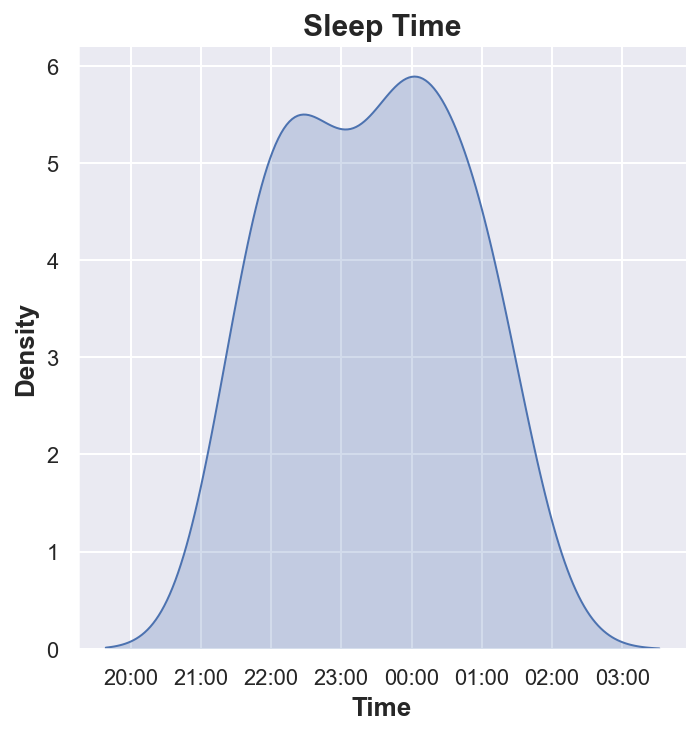

In [69]:
print(f"Mean Sleep time: {sleep_times['dt'].mean().time()}")
print(f"Median Sleep time: {sleep_times['dt'].median().time()}")

fig = sns.displot(sleep_times, x="dt", kind="kde", fill=True)
fig.ax.set_ylabel('Density', fontsize=13, fontweight="bold")
fig.ax.set_xlabel('Time', fontsize=13, fontweight="bold")
fig.ax.set_title('Sleep Time', fontsize=15, fontweight="bold")
fig.ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

## Wake up time distribution

In [70]:
wake_times = df.groupby("UserID", as_index=False).apply(lambda x: x[x.Stage != "wake"].index[-1].time())
wake_times.columns = ["UserID", "WakeTime"]
wake_times.head()

,UserID,WakeTime
0,1066528,05:14:30
1,1360686,08:56:55.768670
2,1449548,05:14:25.713230
3,1455390,09:01:58.005790
4,1818471,05:29:58.285000


In [71]:
wake_times["Date"] = datetime.datetime.now().date()
wake_times["dt"] = wake_times.apply(lambda x: datetime.datetime.combine(x.Date, x.WakeTime), axis=1)
wake_times.head()

,UserID,WakeTime,Date,dt
0,1066528,05:14:30,2022-08-06,2022-08-06 05:14:30.000000
1,1360686,08:56:55.768670,2022-08-06,2022-08-06 08:56:55.768670
2,1449548,05:14:25.713230,2022-08-06,2022-08-06 05:14:25.713230
3,1455390,09:01:58.005790,2022-08-06,2022-08-06 09:01:58.005790
4,1818471,05:29:58.285000,2022-08-06,2022-08-06 05:29:58.285000


Mean Wake up time: 06:08:35.746304
Median Wake up time: 06:14:59.560809


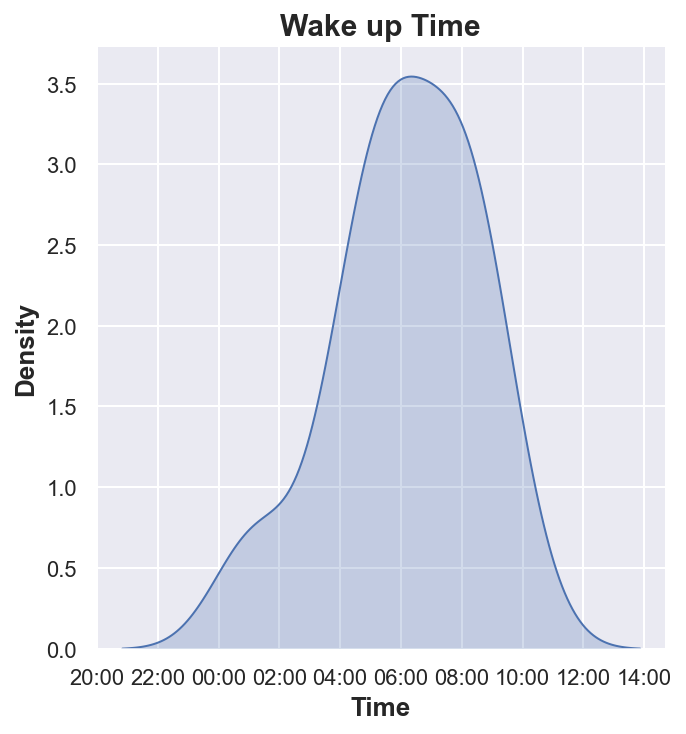

In [72]:
print(f"Mean Wake up time: {wake_times['dt'].mean().time()}")
print(f"Median Wake up time: {wake_times['dt'].median().time()}")

fig = sns.displot(wake_times, x="dt", kind="kde", fill=True)
fig.ax.set_ylabel('Density', fontsize=13, fontweight="bold")
fig.ax.set_xlabel('Time', fontsize=13, fontweight="bold")
fig.ax.set_title('Wake up Time', fontsize=15, fontweight="bold")
fig.ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"));